# 8. Dimensionality Reduction

- Reducing the number of features can massively speed up training
- Sometimes it will also improve performance, but in general it won't
- Dimensionality reduction is also usual for data visualisation

In [78]:
# pydata stack
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams.update({"figure.figsize" : (10, 8), "font.size": 16})

# sklearn
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA, IncrementalPCA

# misc
import time
from sys import getsizeof
import os
import joblib

# useful decorator
def computation_time(func):
    def inner(*args, **kwargs):
        start = time.perf_counter()
        output = func(*args, **kwargs)
        end = time.perf_counter()
        print("Computation time: {:.1f} seconds".format(end - start))
        
        return output

    return inner

In [91]:
# paths
ROOT_DIR = "."
DATASETS_PATH = os.path.join(ROOT_DIR, "datasets")

# creates datasets folder, no error if it already exists
os.makedirs(
    DATASETS_PATH, exist_ok=True
)  

def datasets_path(file_name):
    return os.path.join(DATASETS_PATH, file_name)


# file names - note must be saved as binary file to load in memmap
BREAST_CANCER_INPUTS = "breast-cancer-inputs.npy"

## The Curse of Dimensionality

- In high dimensions, data points are more likely to be close to a boundary and are much futher away from each other on average
- so high-dimensional data sets are sparser and making predictions involves more extrapolation
- The more dimensions, the greater the risk of overfitting
- To maintain given density, training set size has to scale exponentially with dimensions

## Main Approaches for Dimensionality Reduction

**Projection:** onto a lower-dimensional linear subspace.

**Manifold Learning**
- *Manifold assumption/hypothesis:* most real-world high-dimensional datasets lie close to a much lower-dimensional manifold
- Manifold learning works by modelling the manifold on which the training instances lie
- The implicit assumption is that the task will also be simpler if expressed in the lower-dimensional space of the manifold (not always true)

## Pricipal Components Analysis

- Most popular dimensionality reduction algorithm
- Projects onto the hyperplane 'closest' to the data and projects onto it

**Preserving the Variance**
- Principal Compoents Analysis (PCA) works by identify the axis that preserves the maximum amount of variance
- This is also the axis that minimises the mean squared distance between the original dataset and its projection onto that axis

**Principal Components**
- The 1st *principal component* of the data is the axis such that projection of the data onto that axis retains the greatest variance
- The $i$th principal componennt is the axis orthogonal for the first *i-1* principal components such that projection onto that axis retains the greatest variance
- *Note:* PCA identifies unit vectors in the direction of the PCs - these are only unique up to sign so small changes in the data may changes these
- If the $\mathbf{X} = \mathbf{U}\mathbf{\Sigma}\mathbf{V}^T$ is the singular value decomposition (SVD) of $\mathbf{X}$ then the first $i$ column vectors of $\mathbf{V}$ are unit vectors in the direction of the first $i$ principal components
- *Note:* data should be centred for PCA, though Scikit-Learn does this automatically

In [33]:
def load_cancer_data():
    cancer = load_breast_cancer()

    X, y = cancer["data"], cancer["target"]
    feat_names = cancer["feature_names"]
    
    return X, y, feat_names


X, y, feat_names = load_cancer_data()

n_sample, n_feat = X.shape
n_class = len(np.unique(y))

print(n_sample, "Samples")
print(n_feat, "Features")
print(n_class, "Classes")

569 Samples
30 Features
2 Classes


In [41]:
# PCA calculated manually using np.linalg
X_centred = X - X.mean(axis=0)
U, S, Vt = np.linalg.svd(X_centred)
V = Vt.T

# first principal components
pc1 = V[:, 0]
pc2 = V[:, 1]

print("First principal component: ", pc1) 
print("Second principal component: ", pc2) 

First principal component:  [-5.08623202e-03 -2.19657026e-03 -3.50763298e-02 -5.16826469e-01
 -4.23694535e-06 -4.05260047e-05 -8.19399539e-05 -4.77807775e-05
 -7.07804332e-06  2.62155251e-06 -3.13742507e-04  6.50984008e-05
 -2.23634150e-03 -5.57271669e-02  8.05646029e-07 -5.51918197e-06
 -8.87094462e-06 -3.27915009e-06  1.24101836e-06  8.54530832e-08
 -7.15473257e-03 -3.06736622e-03 -4.94576447e-02 -8.52063392e-01
 -6.42005481e-06 -1.01275937e-04 -1.68928625e-04 -7.36658178e-05
 -1.78986262e-05 -1.61356159e-06]
Second principal component:  [ 9.28705650e-03 -2.88160658e-03  6.27480827e-02  8.51823720e-01
 -1.48194356e-05 -2.68862249e-06  7.51419574e-05  4.63501038e-05
 -2.52430431e-05 -1.61197148e-05 -5.38692831e-05  3.48370414e-04
  8.19640791e-04  7.51112451e-03  1.49438131e-06  1.27357957e-05
  2.86921009e-05  9.36007477e-06  1.22647432e-05  2.89683790e-07
 -5.68673345e-04 -1.32152605e-02 -1.85961117e-04 -5.19742358e-01
 -7.68565692e-05 -2.56104144e-04 -1.75471479e-04 -3.05051743e-05

**Projecting Down to $d$ Dimensions**
- You can reduce dimensionality by projecting to the space spanned by the first $d$ principal components
- You can do this by evaluating $\mathbf{X}_d = \mathbf{X}\mathbf{W}_d$, where $\mathbf{W}_d$ is the $n\times d$ matrix consisting of the first $d$ columns of $\mathbf{V}$

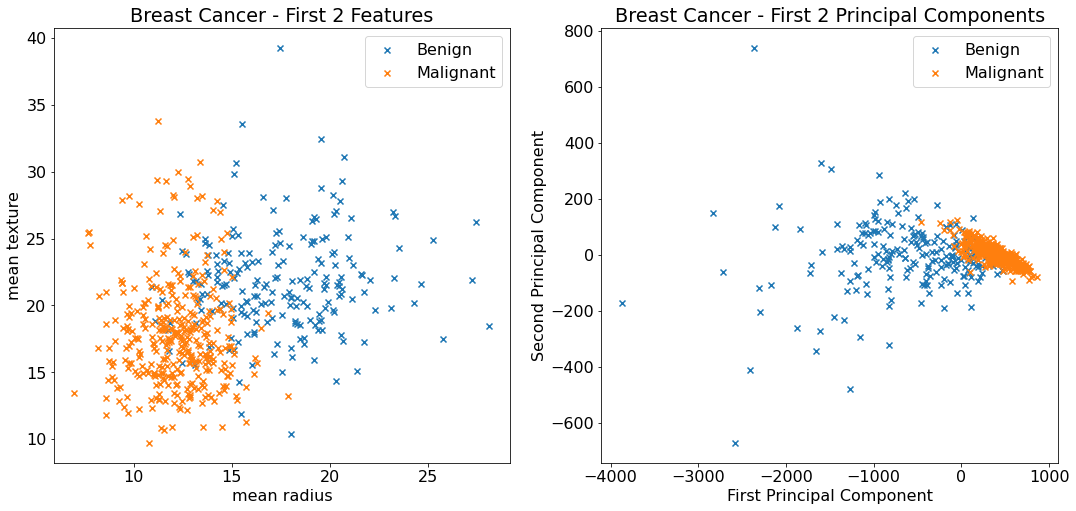

In [37]:
# plot first 2 components against first 2 features
X2 = X_centred @ V[:, :2]

fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# first 2 features
ax = axs[0]
ax.scatter(X[y==0, 0], X[y==0, 1], marker="x", label="Benign")
ax.scatter(X[y==1, 0], X[y==1, 1], marker="x", label="Malignant")

ax.set_xlabel(feat_names[0])
ax.set_ylabel(feat_names[1])

ax.set_title("Breast Cancer - First 2 Features")

ax.legend()

# first 2 pcs
ax = axs[1]
ax.scatter(X2[y==0, 0], X2[y==0, 1], marker="x", label="Benign")
ax.scatter(X2[y==1, 0], X2[y==1, 1], marker="x", label="Malignant")

ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component")

ax.set_title("Breast Cancer - First 2 Principal Components");

ax.legend();

**Using Scikit-Learn**
- `decomposition.PCA(n_components=d)` uses SVD decomposition to implement PCA and project to the first $d$ principal components
- The `components_` attribute holds $\mathbf{W}_d^T$

In [42]:
# pca using sklearn
pca = PCA(n_components=2)
X2 = pca.fit_transform(X)

print("First 2 principal components: ", pca.components_)

First 2 principal components:  [[ 5.08623202e-03  2.19657026e-03  3.50763298e-02  5.16826469e-01
   4.23694535e-06  4.05260047e-05  8.19399539e-05  4.77807775e-05
   7.07804332e-06 -2.62155251e-06  3.13742507e-04 -6.50984008e-05
   2.23634150e-03  5.57271669e-02 -8.05646029e-07  5.51918197e-06
   8.87094462e-06  3.27915009e-06 -1.24101836e-06 -8.54530832e-08
   7.15473257e-03  3.06736622e-03  4.94576447e-02  8.52063392e-01
   6.42005481e-06  1.01275937e-04  1.68928625e-04  7.36658178e-05
   1.78986262e-05  1.61356159e-06]
 [ 9.28705650e-03 -2.88160658e-03  6.27480827e-02  8.51823720e-01
  -1.48194356e-05 -2.68862249e-06  7.51419574e-05  4.63501038e-05
  -2.52430431e-05 -1.61197148e-05 -5.38692831e-05  3.48370414e-04
   8.19640791e-04  7.51112451e-03  1.49438131e-06  1.27357957e-05
   2.86921009e-05  9.36007477e-06  1.22647432e-05  2.89683790e-07
  -5.68673345e-04 -1.32152605e-02 -1.85961117e-04 -5.19742358e-01
  -7.68565692e-05 -2.56104144e-04 -1.75471479e-04 -3.05051743e-05
  -1.57042

**Explained Variance Ratio**
- The *explained variance ratio* of one of the principal components is the proportion of the dataset's variance that lies along that component *(I'm not sure what this means precisely)*
- It can be accessed as the `explained_variance_ratio_` of PCA

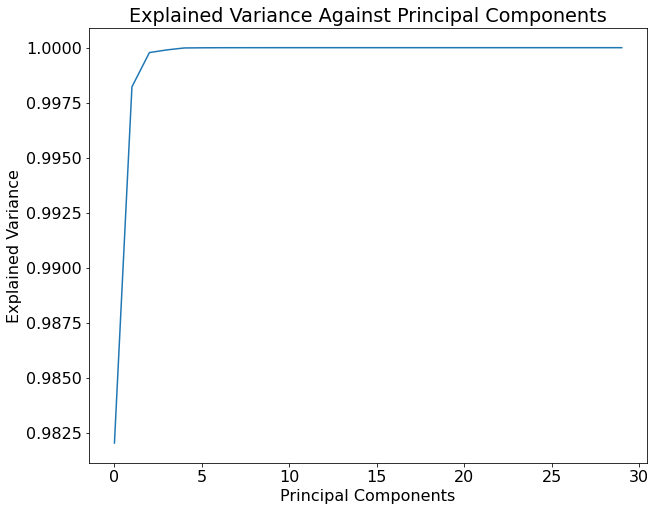

In [47]:
# explained variance against number of principal components
pca = PCA()
pca.fit(X)

fig, ax = plt.subplots()

cumsum = pca.explained_variance_ratio_.cumsum()
ax.plot(cumsum)

ax.set_xlabel("Principal Components")
ax.set_ylabel("Explained Variance")

ax.set_title("Explained Variance Against Principal Components");

So essentially all variance is explained by the first 3 features.

**Choosing the Right Number of Dimensions**
- One way to choose $d$ is find the smallest value that explains a given proportion of the variance
- You can do this by intialised `PCA(n_components=0.95)`
- You can also plot the (cumulative) explained variance against $d$ and find the 'elbow' where the growth starts slowing down

In [58]:
# how many components required to explain 99% of variance?
pca = PCA(n_components=0.99)
pca.fit(X)

pca.n_components_

2

**PCA for Compression**
- Dimesionality reduction will also reduce file sizes
- Applying the inverse transformation `inverse_transform` will give a approximation to the original data
- *Reconstruction error: *the mean squared distance between the original data and the reconstructed data
- The inverse transformation is $\mathbf{X}_{\text{recovered}} = \mathbf{X}_d\mathbf{W}_d^T$

In [60]:
pca = PCA(n_components=2)
X_red = pca.fit_transform(X)
X_rec = pca.inverse_transform(X2)

print("Original dataset: {} bytes".format(getsizeof(X)))
print("Reduced dataset: {} bytes".format(getsizeof(X_red)))
print("Recovered dataset: {} bytes".format(getsizeof(X_rec)))

Original dataset: 136680 bytes
Reduced dataset: 120 bytes
Recovered dataset: 136680 bytes


**Randomized PCA:** a stochastic algorithm that quickly finds an approximation to the first $d$ principal components
- Computational complexity is $O(m\times d^2) + O(d^3)$ instead of $O(m\times n^2) + O(n^3)$ for the full SVD
- You can apply this in Scikit-Learn using `svd_solver="randomized"`
- By default Scikit-Learn uses randomized if $d<0.8 * m$ and full otherwise

In [62]:
# randomised pca
rnd_pca = PCA(n_components = 10, svd_solver="randomized")

**Incremental PCA:** allows you train PCA by feeding in the training one mini-batch at a time
- This doesn't require the whole training set to fit in memory
- Useful for large training sets and for applying PCA online
- Scikit-Learn's `IncrementalPCA` implements this - you must call `partial_fit` on each mini-batch
- Alternatively, `np.memmap` allows you to manipulate a large array as if it were in memory, loading only the data it needs in memory. Since `IncrementalPCA` only uses a small part at a time, you can just call `fit` on the memmap object

In [72]:
# train pca in mini batches
n_batch = 12
inc_pca = IncrementalPCA(n_components=10)
for X_batch in np.array_split(X, n_batch):
    inc_pca.partial_fit(X_batch)


inc_pca.transform(X)

array([[1160.14229906, -293.6520149 ],
       [1269.12258737,   15.43852165],
       [ 995.79390674,   39.14666551],
       ...,
       [ 314.5018092 ,   47.49626682],
       [1124.85819655,   34.02116784],
       [-771.52773429,  -88.51166341]])

In [151]:
# save breast cancer data - must be saved as binary file
np.save(datasets_path(BREAST_CANCER_INPUTS), X)

# load in memmap
X_mm = np.memmap(datasets_path(BREAST_CANCER_INPUTS), dtype="float64", mode="readonly", shape=(n_sample, n_feat))

batch_size = n_sample // n_batch
inc_pca = IncrementalPCA(n_components=5, batch_size=batch_size)

# fitting doesn't work for some reason
#inc_pca.fit(X_mm)